<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Projeto/Cuisine_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
!cp -r '/content/drive/MyDrive/NLP-Project/cuisine-classification-ingredients' 'cuisine-classification-ingredients'

In [3]:
!cp -r '/content/drive/MyDrive/NLP-Project/word-embedding' 'word-embedding'

# Imports

In [ ]:
#!pip install transformers
!pip install gensim --upgrade
!pip install keras
!pip install tensorflow
!pip install keras-tuner --upgrade
!pip install glove-python-binary

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
#GLOVE
from glove import Corpus, Glove
#Neural Network
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,Activation,SimpleRNN,Dropout,Masking,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Data
import json
import os
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Data

## Download

In [8]:
path = 'cuisine-classification-ingredients/train.json'

with open(path, 'r') as f:
  json_file = json.load(f)

In [9]:
df_cuisine = pd.DataFrame(json_file, columns=['id', 'cuisine', 'ingredients'])

In [10]:
df_cuisine = df_cuisine.drop(['id'], axis=1)

In [11]:
df_cuisine = df_cuisine[:10000]

In [12]:
df_cuisine.head(5)

,cuisine,ingredients
0,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,"[water, vegetable oil, wheat, salt]"
4,indian,"[black pepper, shallots, cornflour, cayenne pe..."


## Pre-Processing

In [13]:
def pre_processing(text):
  new = ""
  for word in text.split(','):
    word = re.sub(r'[^\w\s]', '', word.lower())
    word = re.sub(r'[0-9]+', '', word)
    word = re.sub(r'\boz\b', '', word)
    word = re.sub(r'\ba taste of\b', '', word)
    new = new + word.strip() + " "

  return new[:-1]

In [14]:
df_cuisine['ingredients'] = [','.join(x).strip() for x in df_cuisine['ingredients']]

In [15]:
df_cuisine['ingredients'] = [pre_processing(x) for x in df_cuisine['ingredients']]

In [16]:
X = df_cuisine['ingredients']
y = df_cuisine['cuisine']

# dados de teste = 20% do treinamento
X_train_cuisine, X_test_cuisine, y_train_cuisine, y_test_cuisine = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test_cuisine, X_valid_cuisine, y_test_cuisine, y_valid_cuisine = train_test_split(X, y, test_size=0.5)

In [17]:
y_train_cuisine = pd.Categorical(y_train_cuisine)
y_train_int_cuisine = y_train_cuisine.codes

y_valid_cuisine = pd.Categorical(y_valid_cuisine)
y_valid_int_cuisine = y_valid_cuisine.codes

y_test_cuisine = pd.Categorical(y_test_cuisine)
target_names_cuisine = y_test_cuisine.categories
y_test_int_cuisine = y_test_cuisine.codes

y_train_cuisine = to_categorical(y_train_int_cuisine)
y_valid_cuisine = to_categorical(y_valid_int_cuisine)
y_test_cuisine = to_categorical(y_test_int_cuisine)

# Embeddings

In [148]:
MAX_LENGTH = 50

## Word2Vec

In [160]:
def create_embedding_w2v(tokenizer, model, vocab_size, embedding_dim):
  embedding_w2v = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if word in model.wv:
      embedding_w2v[i] = model.wv.get_vector(word)
    else:
      embedding_w2v[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)
  return embedding_w2v

In [161]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_cuisine)
vocab_size_cuisine = len(tokenizer.word_index) + 1

In [162]:
# Train Data
encoded_w2v = tokenizer.texts_to_sequences(X_train_cuisine)
X_train_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_w2v = tokenizer.texts_to_sequences(X_valid_cuisine)
X_valid_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_w2v = tokenizer.texts_to_sequences(X_test_cuisine)
X_test_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [163]:
# EMBEDDING LAYER

EMBEDDING_DIM_W2V = 100

sentences = [sentence.split() for sentence in X_train_cuisine]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM_W2V, min_count=1, window=5, sg=1,workers=4)

embedding_w2v = create_embedding_w2v(tokenizer, model_word2vec, vocab_size_cuisine, EMBEDDING_DIM_W2V)

## GloVe

In [61]:
def create_embedding_glove(glove, vocab_size, embedding_dim):
  embedding_glove = np.zeros((vocab_size, embedding_dim))
  for i, word in enumerate(glove.dictionary):
    embedding_glove[i+1] = glove.word_vectors[i]
  return embedding_glove

In [94]:
def texts_to_sequences(df_text):
  encoded_glove = []
  for sentence in df_text:
    xs = []
    for word in sentence.split():
      if glove.dictionary.get(word) is not None:
        xs.append(glove.dictionary[word]+1)
      else:
        xs.append(0)
    encoded_glove.append(xs)
  return encoded_glove

In [78]:
corpus = Corpus() 
 
sentences = [sentence.split() for sentence in X_train_cuisine]
corpus.fit(sentences, window=10)

In [79]:
# EMBEDDING LAYER

EMBEDDING_DIM_GLV = 100

glove = Glove(no_components=EMBEDDING_DIM_GLV, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=2)
glove.add_dictionary(corpus.dictionary)
embedding_glove = create_embedding_glove(glove, vocab_size_cuisine, EMBEDDING_DIM_GLV)

In [95]:
# Train Data
encoded_glove = texts_to_sequences(X_train_cuisine)
X_train_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_glove = texts_to_sequences(X_valid_cuisine)
X_valid_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_glove = texts_to_sequences(X_test_cuisine)
X_test_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# CNN

In [150]:
class CNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Conv1D(filters=hp.Choice("conv", [64,128,256]), kernel_size=6, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hp.Choice("dense1", [64,128]), activation='relu'))
    model.add(Dense(hp.Choice("dense2", [32,64]), activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [164]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v_cuisine], input_length=MAX_LENGTH, trainable=False)

In [165]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [166]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [167]:
tuner.search(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine),epochs=50)

Trial 11 Complete [00h 00m 06s]
val_accuracy: 0.5157999992370605

Best val_accuracy So Far: 0.5342000126838684
Total elapsed time: 00h 01m 58s


In [168]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [169]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [170]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           215000    
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 256)           153856    
                                                                 
 dropout_1 (Dropout)         (None, 45, 256)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [171]:
history_fine = model_cuisine.fit(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 8s 30ms/step - loss: 2.5382 - accuracy: 0.2755 - val_loss: 2.4167 - val_accuracy: 0.4406
Epoch 2/100
250/250 [==============================] - 6s 23ms/step - loss: 1.9589 - accuracy: 0.4804 - val_loss: 2.0347 - val_accuracy: 0.5054
Epoch 3/100
250/250 [==============================] - 6s 23ms/step - loss: 1.6523 - accuracy: 0.5272 - val_loss: 1.8264 - val_accuracy: 0.5532
Epoch 4/100
250/250 [==============================] - 6s 23ms/step - loss: 1.5165 - accuracy: 0.5512 - val_loss: 1.6999 - val_accuracy: 0.5714
Epoch 5/100
250/250 [==============================] - 6s 23ms/step - loss: 1.4453 - accuracy: 0.5634 - val_loss: 1.6260 - val_accuracy: 0.5778
Epoch 6/100
250/250 [==============================] - 6s 22ms/step - loss: 1.3785 - accuracy: 0.5724 - val_loss: 1.5676 - val_accuracy: 0.5900
Epoch 7/100
250/250 [==============================] - 6s 22ms/step - loss: 1.3343 - accuracy: 0.5889 - val_loss: 1.5090 - val_accuracy:

In [172]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [173]:
y_prob = model_cuisine.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.79      0.85      0.82        62
     british       0.85      0.86      0.86        87
cajun_creole       0.93      0.90      0.92       217
     chinese       0.89      0.93      0.91       337
    filipino       0.84      0.84      0.84        91
      french       0.84      0.92      0.88       333
       greek       0.96      0.88      0.91       152
      indian       0.95      0.96      0.95       363
       irish       0.89      0.84      0.86        85
     italian       0.98      0.94      0.96       953
    jamaican       0.89      0.89      0.89        81
    japanese       0.92      0.88      0.90       178
      korean       0.95      0.88      0.91       108
     mexican       0.96      0.99      0.97       825
    moroccan       0.95      0.83      0.89       101
     russian       0.91      0.84      0.87        62
 southern_us       0.91      0.92      0.91       563
     spanish       0.85    

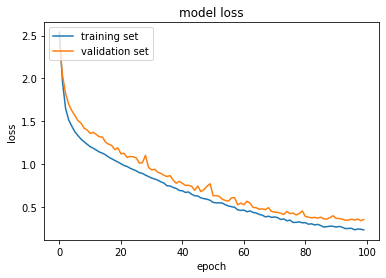

In [174]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

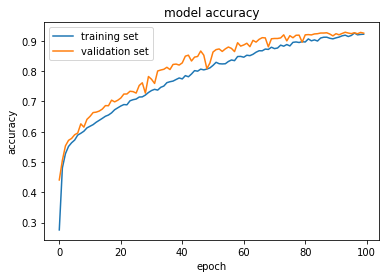

In [175]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

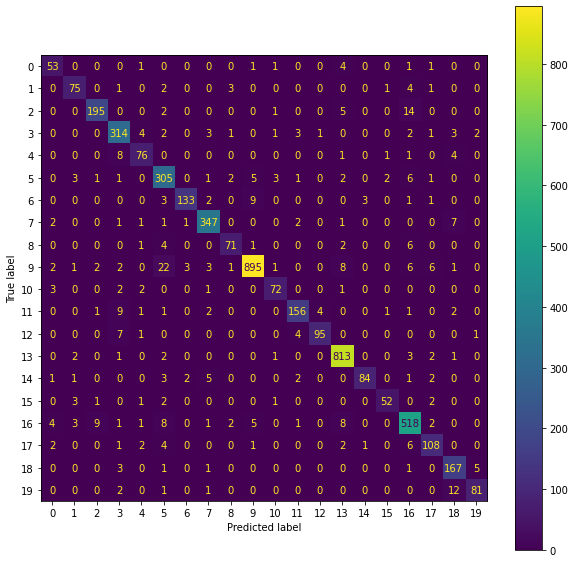

In [176]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()

### GLOVE

In [96]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [99]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [100]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [101]:
tuner.search(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine),epochs=50)

Trial 11 Complete [00h 00m 06s]
val_accuracy: 0.4480000138282776

Best val_accuracy So Far: 0.47760000824928284
Total elapsed time: 00h 01m 46s


In [102]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [103]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [104]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           215000    
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 128)           76928     
                                                                 
 dropout_1 (Dropout)         (None, 45, 128)           0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [105]:
history_fine = model_cuisine.fit(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine), epochs=100) 

Epoch 1/100
250/250 [==============================] - 4s 15ms/step - loss: 2.4650 - accuracy: 0.2848 - val_loss: 2.4202 - val_accuracy: 0.4094
Epoch 2/100
250/250 [==============================] - 3s 13ms/step - loss: 2.0206 - accuracy: 0.4380 - val_loss: 2.1011 - val_accuracy: 0.4760
Epoch 3/100
250/250 [==============================] - 3s 13ms/step - loss: 1.7970 - accuracy: 0.4770 - val_loss: 1.9587 - val_accuracy: 0.4910
Epoch 4/100
250/250 [==============================] - 3s 14ms/step - loss: 1.6739 - accuracy: 0.5036 - val_loss: 1.8755 - val_accuracy: 0.5266
Epoch 5/100
250/250 [==============================] - 3s 14ms/step - loss: 1.5968 - accuracy: 0.5190 - val_loss: 1.7702 - val_accuracy: 0.5394
Epoch 6/100
250/250 [==============================] - 3s 14ms/step - loss: 1.5359 - accuracy: 0.5329 - val_loss: 1.7071 - val_accuracy: 0.5510
Epoch 7/100
250/250 [==============================] - 3s 13ms/step - loss: 1.4865 - accuracy: 0.5441 - val_loss: 1.6660 - val_accuracy:

In [106]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [107]:
y_prob = model_cuisine.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

              precision    recall  f1-score   support

   brazilian       0.85      0.53      0.65        62
     british       0.78      0.60      0.68        87
cajun_creole       0.93      0.81      0.87       217
     chinese       0.87      0.87      0.87       337
    filipino       0.84      0.69      0.76        91
      french       0.71      0.84      0.77       333
       greek       0.96      0.80      0.87       152
      indian       0.94      0.94      0.94       363
       irish       0.94      0.35      0.51        85
     italian       0.92      0.92      0.92       953
    jamaican       0.90      0.68      0.77        81
    japanese       0.74      0.85      0.79       178
      korean       0.94      0.78      0.85       108
     mexican       0.95      0.95      0.95       825
    moroccan       0.96      0.80      0.88       101
     russian       0.75      0.61      0.67        62
 southern_us       0.70      0.92      0.79       563
     spanish       0.92    

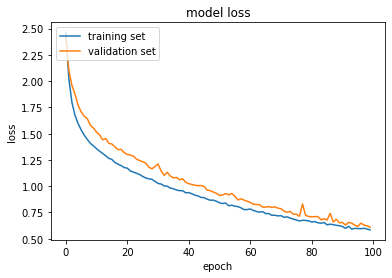

In [108]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

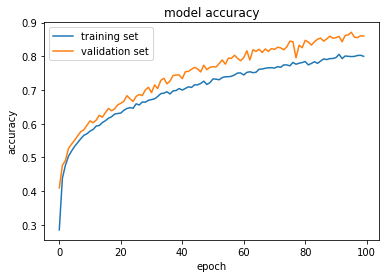

In [109]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

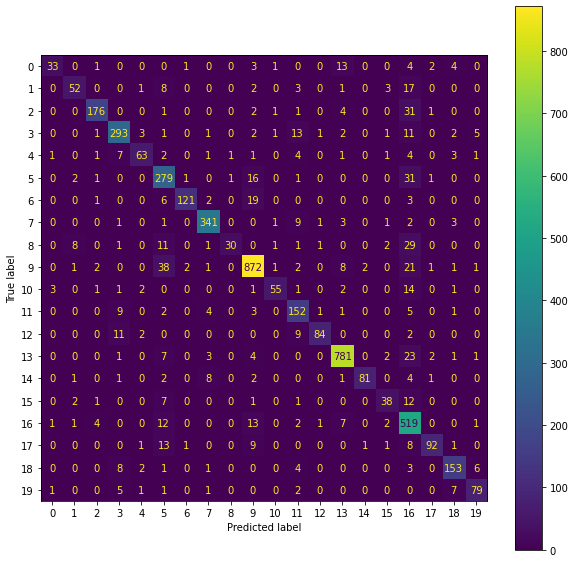

In [110]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()

# LSTM

In [179]:
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(hp.Choice("lstm", [64,128,256]), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(hp.Choice("dense1", [32,64]), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [180]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [181]:
model_LSTM = LSTMHyperModel(embedding_layer, 20)

In [182]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [183]:
tuner.search(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine),epochs=50)

Trial 6 Complete [00h 02m 24s]
val_accuracy: 0.35519999265670776

Best val_accuracy So Far: 0.3693999946117401
Total elapsed time: 00h 07m 49s


In [184]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [185]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [186]:
model_cuisine.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           215000    
                                                                 
 masking_1 (Masking)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               365568    
                                                                 
 dense_2 (Dense)             (None, 32)                8224      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                660       
                                                                 
Total params: 589,452
Trainable params: 374,452
Non-tr

In [ ]:
history_fine = model_cuisine.fit(X_train_w2v_padded,y_train_cuisine,validation_data=(X_valid_w2v_padded,y_valid_cuisine), epochs=100) 

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()

### GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size_cuisine, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 20)

In [ ]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine),epochs=50)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model_cuisine = tuner.hypermodel.build(best_hps)

In [ ]:
model_cuisine.summary()

In [ ]:
history_fine = model_cuisine.fit(X_train_glove_padded,y_train_cuisine,validation_data=(X_valid_glove_padded,y_valid_cuisine), epochs=100) 

In [ ]:
target_names = pd.Categorical(df_cuisine['cuisine']).categories

In [ ]:
y_prob = model_cuisine.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int_cuisine,y_pred, target_names=target_names))

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int_cuisine, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(10) 
fig.set_figheight(10)
plt.show()